In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

## Loop downsample size - data generator randomization, NAICS base
Randomize training during fit (shuffled), loop downsampling training data.  Loop the downsample fraction.  (Fixed random injection at 10%

Base NAICS only, and data with no missing values

*This script takes about 2 hours on my MacBook Air*

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf

In [3]:
from pathlib import Path
import importlib, pickle
from sklearn import model_selection
from sklearn.model_selection import train_test_split

In [4]:
import pandas as pd
import os
import re

import keras
from tensorflow.keras import layers, optimizers, losses, metrics, Model
from sklearn import preprocessing, feature_extraction, model_selection
from IPython.display import display, HTML
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
import matplotlib.ticker as ticker

In [6]:
from keras.callbacks import EarlyStopping

In [7]:
from sba_nn.sba_nn import sbnn_metrics, sbnn_model, sbnn_plot
from sba_nn.sba_nn.sbnn_model import CatInjectGenerator

In [8]:
sbnn_plot.plot_defaults()

## Input Data

In [9]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed_nomiss.parquet'))

In [10]:
with open(Path(setup.temp_path).joinpath('01_DATA_features.pkl'), 'rb') as fin:
    imputer_features = pickle.load(fin)

In [11]:
with open(Path(setup.temp_path).joinpath('01_DATA_naics_max_encodings.pkl'), 'rb') as fin:
    naics_max_levels= pickle.load(fin)

##### Features

In [12]:
# Numeric features
features_numeric = [f for f in imputer_features if 'NAICS' not in f]
features_numeric_len = len(features_numeric)
print(features_numeric)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'missingindicator_LowDoc', 'missingindicator_new_business', 'missingindicator_urban_flag']


In [13]:
###### NAICS feature
features_naics = ['NAICS']
features_naics_max_levels  = [naics_max_levels[n] for n in features_naics]
features_naics_emb_dim = [setup.nn_naics_embed_size_dict[n] for n in features_naics]

In [14]:
print(features_naics_max_levels)
print(features_naics_emb_dim)

[1170]
[8]


##### Datasets for train, validation

In [15]:
X = sba_loans[['dset', 'LoanNr_ChkDgt'] + features_numeric + features_naics].set_index('LoanNr_ChkDgt').sort_index()

In [16]:
X_train = X[X['dset'] == 'train'].drop(columns='dset')
y_train = sba_loans[sba_loans['dset'] == 'train'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'training X: {X_train.shape}, y:{y_train.shape}')

training X: (446848, 11), y:(446848,)


In [17]:
X_val = X[X['dset'] == 'val'].drop(columns='dset')
y_val = sba_loans[sba_loans['dset'] == 'val'].set_index('LoanNr_ChkDgt').sort_index()['target']
print(f'val X: {X_val.shape}, y:{y_val.shape}')

val X: (95604, 11), y:(95604,)


In [18]:
base_thresh = y_train.mean()
print(base_thresh)

0.20230592953308507


## Create, fit model

## Loop for different fits

In [19]:
def gen_fit_loop(rate=0.1, injection_rate = 0.1):
    this_model = sbnn_model.create_emb_model(features_numeric_len,
                                         features_naics_max_levels,
                                         features_naics_emb_dim,
                                         naics_embedding_names = features_naics,
                                         hidden_size = setup.nn_layer_sizes,
                                         activation='tanh',
                                         lr=setup.nn_learning_rate,
                                         opt_func = setup.nn_optimizer,
                                         dropout = setup.nn_dropout)
    
    # Downsample
    train_samp, _ = train_test_split(X_train.index,
                                train_size=rate,
                                random_state=343)
    X_train_ds = X_train.loc[train_samp, :]
    y_train_ds = y_train.loc[train_samp]
    
    
    generator = CatInjectGenerator(X_train_ds, y_train_ds,
                               categorical_columns=features_naics,
                               batch_size = setup.nn_batch_size,
                               injection_rate = injection_rate,
                               injection_value = 1)
    callback = keras.callbacks.EarlyStopping(patience=3)
    
    this_history = this_model.fit(generator,
                              batch_size=setup.nn_batch_size,
                              epochs = setup.nn_epochs,
                              validation_data=([X_val[features_numeric]] + [X_val[f] for f in features_naics], 
                                               y_val),
                              shuffle=True,
                             callbacks=[callback])
    this_history_df = sbnn_model.process_history(this_history)
    this_history_df['rate'] = rate
    
    # Predictions then metrics
    this_predict = this_model.predict([X[features_numeric]]+ [X[f] for f in features_naics])
    this_predict_df = pd.DataFrame(this_predict, index=X.index) \
        .set_axis(['predict_prob'], axis=1) \
        .reset_index() \
        .merge(sba_loans[['target', 'LoanNr_ChkDgt', 'dset', 'dset_naics_holdout', 'NAICS']], 
               on='LoanNr_ChkDgt')
    
    # Threshold tune
    this_pred_train = this_predict_df[this_predict_df['dset'] == 'train']
    thresh_tune_data = sbnn_metrics.get_f1_frame(this_pred_train['target'], 
                                        this_pred_train['predict_prob'])
    thresh_tune_data.sort_values('f1', ascending=False, inplace=True)
    best_thresh = thresh_tune_data['thresh'].iloc[0]
    this_predict_df['predict_bin'] = sbnn_metrics.get_binary_predictions(this_predict_df['predict_prob'], 
                                                                            best_thresh)
    
    this_metrics_dset = this_predict_df.groupby('dset') \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics_test = this_predict_df[this_predict_df['dset'] == 'test'] \
        .groupby(['dset', 'dset_naics_holdout']) \
        .apply(lambda x: sbnn_metrics.dset_metrics(x.target, x.predict_bin, x.predict_prob)) \
        .reset_index()
    this_metrics = pd.concat([this_metrics_dset, this_metrics_test])
    this_metrics['rate'] = rate
    this_metrics['thresh'] = best_thresh
    this_metrics['train_size'] = len(X_train_ds)
    
    return this_history_df, this_metrics


## Run Loop

In [20]:
sample_rate_vals = [0.01, 0.05, 0.1, 0.2, 0.4, 0.7, 0.9, 0.95, 0.99]

In [21]:
history = pd.DataFrame()
metrics = pd.DataFrame()

In [22]:
%%capture
for r in sample_rate_vals:
    this_hist, this_met = gen_fit_loop(r)
    history = pd.concat([history, this_hist])
    metrics = pd.concat([metrics, this_met])

2024-05-25 07:27:09.795150: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2024-05-25 07:27:09.795180: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-05-25 07:27:09.795187: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-05-25 07:27:09.795230: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-25 07:27:09.795251: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2024-05-25 07:27:10.679486: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-05-25 07:27:14.929113: I t

In [23]:
history['epoch'] = history.groupby('rate').cumcount()
history.to_csv(Path(setup.temp_path).joinpath('34_REPORT_loop_history.csv'))

In [24]:
metrics.to_csv(Path(setup.temp_path).joinpath('34_REPORT_loop_metrics.csv'))

In [25]:
metrics[metrics['dset_naics_holdout'] == 0]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh,train_size
0,test,0.573103,0.405601,0.282806,0.716868,0.315488,0.672187,0.0,0.01,0.18,4468
0,test,0.591605,0.423279,0.296796,0.737626,0.333983,0.693737,0.0,0.05,0.18,22342
0,test,0.616124,0.434722,0.310157,0.726500,0.346791,0.705166,0.0,0.10,0.20,44684
0,test,0.645751,0.439228,0.323736,0.682823,0.364643,0.714591,0.0,0.20,0.26,89369
0,test,0.649853,0.444765,0.328086,0.690240,0.373609,0.721353,0.0,0.40,0.22,178739
0,test,0.654688,0.445382,0.330564,0.682411,0.377877,0.724462,0.0,0.70,0.22,312793
0,test,0.648231,0.447084,0.328427,0.699974,0.379639,0.726398,0.0,0.90,0.26,402163
0,test,0.661019,0.447273,0.334431,0.675045,0.380609,0.726943,0.0,0.95,0.26,424505
0,test,0.657294,0.447776,0.332865,0.683853,0.380559,0.726971,0.0,0.99,0.22,442379


In [26]:
metrics[metrics['dset_naics_holdout'] == 1]

,dset,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score,dset_naics_holdout,rate,thresh,train_size
1,test,0.519629,0.414037,0.273505,0.851619,0.315432,0.698339,1.0,0.01,0.18,4468
1,test,0.628951,0.423740,0.306835,0.684560,0.315174,0.694951,1.0,0.05,0.18,22342
1,test,0.587205,0.429574,0.296414,0.779960,0.340633,0.710439,1.0,0.10,0.20,44684
1,test,0.620915,0.434539,0.309175,0.730907,0.344555,0.715300,1.0,0.20,0.26,89369
1,test,0.651041,0.436524,0.321821,0.678275,0.346520,0.716550,1.0,0.40,0.22,178739
1,test,0.640622,0.436554,0.317468,0.698612,0.350059,0.717207,1.0,0.70,0.22,312793
1,test,0.637300,0.437557,0.316626,0.707951,0.351014,0.719131,1.0,0.90,0.26,402163
1,test,0.653476,0.437581,0.323388,0.676442,0.353664,0.720219,1.0,0.95,0.26,424505
1,test,0.638117,0.437931,0.317122,0.707428,0.351993,0.720161,1.0,0.99,0.22,442379


## Plots

In [27]:
#metrics = pd.read_csv(Path(setup.temp_path).joinpath('34_REPORT_loop_metrics.csv'))
#history = pd.read_csv(Path(setup.temp_path).joinpath('34_REPORT_loop_history.csv'))

In [28]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

##### Metrics

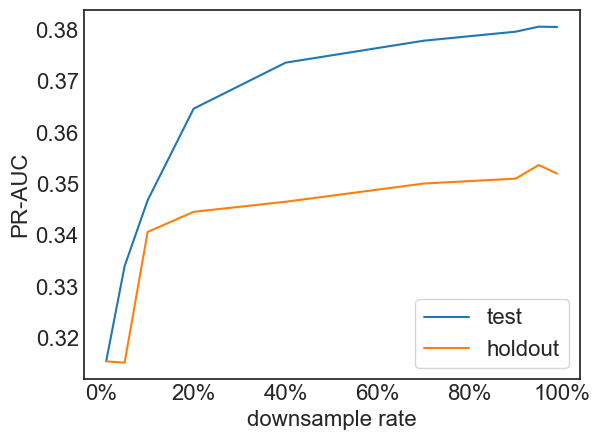

In [29]:
fig = sbnn_plot.plot_metric_dependence(metrics, xformatter = ticker.PercentFormatter(1),
                                      ylabel='PR-AUC',
                            xlabel='downsample rate')
fig.savefig(Path(setup.temp_path).joinpath('34_PLOT_average_precision.png'),
            bbox_inches='tight')

##### History

In [30]:
importlib.reload(sbnn_plot)

<module 'sba_nn.sba_nn.sbnn_plot' from '/Users/valeriecarey/Documents/projects/2024_05_blog_nn_rand/code/sba_nn/sba_nn/sbnn_plot.py'>

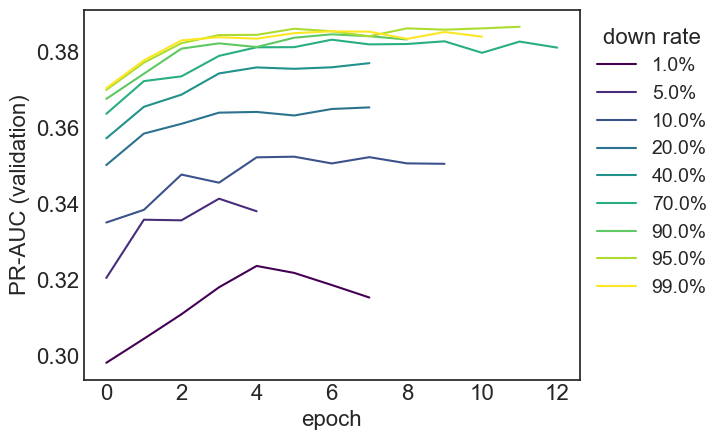

In [31]:
fig = sbnn_plot.plot_history_group(history,
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'PR-AUC (validation)',
                                  leg_title='down rate')
fig.savefig(Path(setup.temp_path).joinpath('34_PLOT_hostory_val_auc.png'),
            bbox_inches='tight')

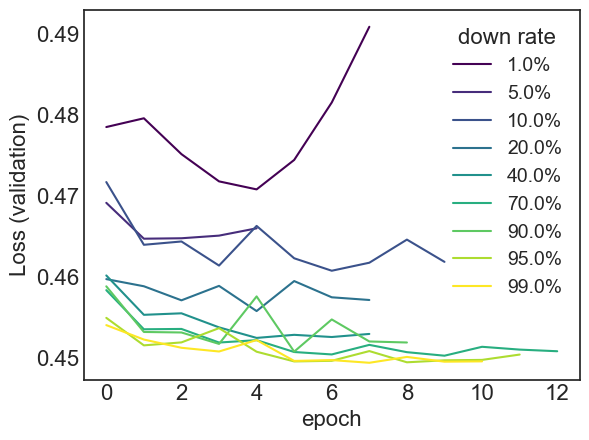

In [32]:
fig = sbnn_plot.plot_history_group(history,'val_loss',
                                  col_format_func = lambda x:f'{float(x):.1%}',
                                  ylabel = 'Loss (validation)',
                                  leg_title='down rate')
fig.savefig(Path(setup.temp_path).joinpath('34_PLOT_hostory_val_loss.png'),
            bbox_inches='tight')

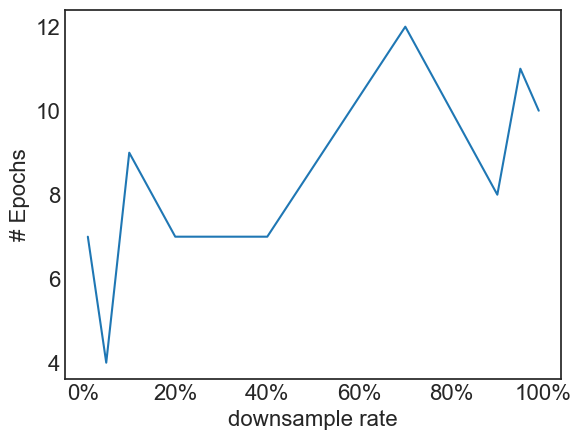

In [33]:
fig = sbnn_plot.plot_epoch_agg(history,
                               xformatter = ticker.PercentFormatter(1),
                               ylabel='# Epochs',
                               xlabel='downsample rate')
fig.savefig(Path(setup.temp_path).joinpath('34_PLOT_hostory_epochs.png'),
            bbox_inches='tight')